# Analysis for Figure 1C SEC elutions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind

import itertools
from scipy import stats
from statsmodels.stats.multitest import multipletests




In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_1_exports'
data_folder = '../all_data/Figure_1_data'

### Uses data from eCM349

In [3]:
df = pd.read_excel('/'.join([data_folder,'Fig1C-raw SEC all elution data.xlsx']))
df

,Fluorphore,DNA_name,rep,volume,rep1,rep2,rep3
0,GFP,Blank,1,0,4889,4366,4363
1,GFP,Blank,1,250,56,64,78
2,GFP,Blank,1,500,128,151,131
3,GFP,Blank,1,750,104,92,120
4,GFP,Blank,1,900,129,136,153
...,...,...,...,...,...,...,...
397,Cy5,Cat,3,2100,48,48,54
398,Cy5,Cat,3,2600,30,35,37
399,Cy5,Cat,3,3100,11,16,14
400,Cy5,Cat,3,3600,6,7,6


## Notes about the data:
* The 0 volume samples are for the samples measured prior to SEC
* rep indicates biological replicate
* sub_rep indicates technical replicate measurements as there is variance in the split GFP binding

In [16]:
data = df.set_index(['Fluorphore', 'DNA_name', 'rep', 'volume']).stack().reset_index().rename(columns={'level_4':'sub_rep',0:'AU'})
data = data.set_index(['DNA_name', 'rep', 'volume','sub_rep','Fluorphore']).unstack().reset_index()
data.columns = data.columns.droplevel()
data.columns = ['DNA_name', 'rep', 'volume','sub_rep','Cy5','GFP']
data = data[data['DNA_name'] != 'MscL']
data

,DNA_name,rep,volume,sub_rep,Cy5,GFP
0,AqpZ,1,0,rep1,1302,38239
1,AqpZ,1,0,rep2,1236,33528
2,AqpZ,1,0,rep3,1232,31119
3,AqpZ,1,250,rep1,1,54
4,AqpZ,1,250,rep2,1,54
...,...,...,...,...,...,...
445,Cat,3,3600,rep2,7,3454
446,Cat,3,3600,rep3,6,3609
447,Cat,3,4100,rep1,4,217
448,Cat,3,4100,rep2,2,142


## Statistical analysis

### Liposome Peak

In [21]:
df = data.groupby(['DNA_name', 'volume','rep'])[['GFP','Cy5']].mean().reset_index()
df

,DNA_name,volume,rep,GFP,Cy5
0,AqpZ,0,1,34295.333333,1256.666667
1,AqpZ,0,2,29513.333333,1186.666667
2,AqpZ,0,3,21126.000000,1207.000000
3,AqpZ,250,1,52.666667,0.666667
4,AqpZ,250,2,87.666667,0.000000
...,...,...,...,...,...
145,Cat,3600,2,3236.333333,2.666667
146,Cat,3600,3,3058.000000,6.333333
147,Cat,4100,1,240.333333,1.000000
148,Cat,4100,2,272.333333,1.000000


In [53]:
def multiple_hypothesis_analysis(df, protein_column, peak_fraction, signal):
    """
    Conduct one-way ANOVA followed by pairwise t-tests (Welch's by default) 
    with multiple-hypothesis correction (Bonferroni).
    Also computes the fold difference between group means for each comparison.
    """
    print(f"\n--- Analysis for {signal} at {peak_fraction} uL ---")
    df_peak = df[df['volume'] == peak_fraction]
    conditions = df_peak[protein_column].unique()
    
    # Group the data for ANOVA
    group_data = [
        df_peak[df_peak[protein_column] == cond][signal].dropna() 
        for cond in conditions
    ]

    # Conduct one-way ANOVA
    f_stat, p_anova = stats.f_oneway(*group_data)
    print(f"One-way ANOVA F={f_stat:.3f}, p={p_anova:.3g}")

    # If overall ANOVA is significant, proceed with post-hoc pairwise tests
    if p_anova < 0.05:
        comparisons = []
        p_values = []
        fold_diffs = []

        for cond1, cond2 in itertools.combinations(conditions, 2):
            data1 = df_peak[df_peak[protein_column] == cond1][signal].dropna()
            data2 = df_peak[df_peak[protein_column] == cond2][signal].dropna()

            # Welch’s t-test for pairwise comparison
            t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            p_values.append(p_val)
            comparisons.append(f"{cond1} vs {cond2}")
            
            # Compute fold difference: mean1 / mean2
            mean1 = data1.mean()
            mean2 = data2.mean()

            if mean2 == 0:
                # if mean2 is zero but mean1 is not, ratio -> inf or undefined
                if mean1 != 0:
                    fold_diff = float('inf') if mean1 > 0 else float('nan')
                else:
                    fold_diff = 1.0  # both means are zero
            else:
                fold_diff = mean1 / mean2

            fold_diffs.append(fold_diff)

        # Bonferroni correction for multiple comparisons
        reject, pvals_corr, _, _ = multipletests(p_values, method='bonferroni')

        # Print results for each pair
        for comp, raw_p, corr_p, rej, fold_diff in zip(comparisons, p_values, pvals_corr, reject, fold_diffs):
            print(
                f"{comp}: \n"
                f"    - Raw p-value = {raw_p:.3g}\n"
                f"    - Corrected p-value = {corr_p:.3g}\n"
                f"    - Significant (reject H0)? = {rej}\n"
                f"    - Fold difference (mean1/mean2) = {fold_diff:.3g}"
            )
    else:
        print("No significant differences found.")



# Combine all technical replicates
df = data.groupby(['DNA_name', 'volume','rep'])[['GFP','Cy5']].mean().reset_index()
df = df[df['volume'] >= 500]

# Conduct multiple hypothesis analysis
# Cy5 signal at 1200 uL (The fraction where liposomes are expected to elute from the SEC column)
peak_fraction = 1200
multiple_hypothesis_analysis(df, 'DNA_name', peak_fraction, 'Cy5')

# GFP signal at 1200 uL (The fraction where liposomes are expected to elute from the SEC column)
peak_fraction = 1200
multiple_hypothesis_analysis(df, 'DNA_name', peak_fraction, 'GFP')

# Cy5 signal at 3100 uL (The fraction where the protein is expected to elute from the SEC column)
peak_fraction = 3100
multiple_hypothesis_analysis(df, 'DNA_name', peak_fraction, 'Cy5')

# GFP signal at 3100 uL (The fraction where the protein is expected to elute from the SEC column)
peak_fraction = 3100
multiple_hypothesis_analysis(df, 'DNA_name', peak_fraction, 'GFP')




--- Analysis for Cy5 at 1200 uL ---
One-way ANOVA F=0.767, p=0.505
No significant differences found.

--- Analysis for GFP at 1200 uL ---
One-way ANOVA F=97.129, p=2.69e-05
AqpZ vs Blank: 
    - Raw p-value = 0.00136
    - Corrected p-value = 0.00408
    - Significant (reject H0)? = True
    - Fold difference (mean1/mean2) = 8.33
AqpZ vs Cat: 
    - Raw p-value = 0.000802
    - Corrected p-value = 0.00241
    - Significant (reject H0)? = True
    - Fold difference (mean1/mean2) = 12.6
Blank vs Cat: 
    - Raw p-value = 0.648
    - Corrected p-value = 1
    - Significant (reject H0)? = False
    - Fold difference (mean1/mean2) = 1.52

--- Analysis for Cy5 at 3100 uL ---
One-way ANOVA F=2.156, p=0.197
No significant differences found.

--- Analysis for GFP at 3100 uL ---
One-way ANOVA F=778.467, p=5.66e-08
AqpZ vs Blank: 
    - Raw p-value = 0.0264
    - Corrected p-value = 0.0792
    - Significant (reject H0)? = False
    - Fold difference (mean1/mean2) = 1.5
AqpZ vs Cat: 
    - Raw p-

## Plotting

In [44]:
colors = ["#0072B2", "#000000", "#D2042D"] # Blue, black, red
hue_order = ['AqpZ', 'Blank', 'Cat']
sns.set_palette(sns.color_palette(colors))

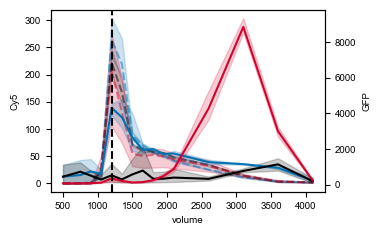

In [54]:
t = df[df['volume'] != 0]
fig,ax = plt.subplots(figsize=[9*cm,6*cm])


sns.lineplot(data=t,x='volume',y='Cy5',hue='DNA_name',ls='--',alpha=0.5,ax=ax,hue_order=hue_order)
ax2 = plt.twinx()
sns.lineplot(data=t,x='volume',y='GFP',hue='DNA_name', ax=ax2,hue_order=hue_order)
ax.get_legend().remove()
ax2.get_legend().remove()
plt.axvline(1200,color='k',ls='--')
# plt.savefig(f'{fig_folder}/all_profiles.svg',format='svg',dpi=300)

plt.show()

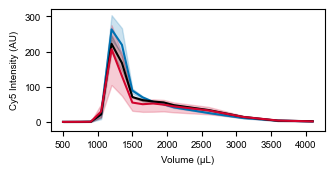

In [55]:
t = df[df['volume'] != 0]

fig,ax = plt.subplots(figsize=[9*cm,4*cm])
sns.lineplot(data=t,x='volume',y='Cy5',hue='DNA_name',ax=ax,hue_order=hue_order)
ax.get_legend().remove()

plt.ylim([-25,320])
plt.xlabel('Volume (μL)')
plt.ylabel('Cy5 Intensity (AU)')
plt.savefig(f'{fig_folder}/Fig1C-all_Cy5_profiles.svg',format='svg',dpi=300)

plt.show()

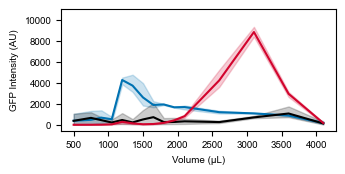

In [56]:
t = df[df['volume'] != 0]
fig,ax = plt.subplots(figsize=[9*cm,4*cm])

sns.lineplot(data=t,x='volume',y='GFP',hue='DNA_name',ax=ax,hue_order=hue_order)
ax.get_legend().remove()

plt.ylim([-500,11000])
plt.xlabel('Volume (μL)')
plt.ylabel('GFP Intensity (AU)')

plt.savefig(f'{fig_folder}/Fig1C-all_GFP_profiles.svg',format='svg',dpi=300)
plt.show()

### Data export

In [10]:
export = data[data['volume'] != 0].copy()
export = export.rename(columns={
    'rep':'Biological_rep',
    'sub_rep':'Technical_rep',
    'volume':'Elution_volume',
})

# export.to_excel(f'./{data_folder}/Fig1C-SEC_data.xlsx')

### Calibration Curve

R2 score for fit: 0.995


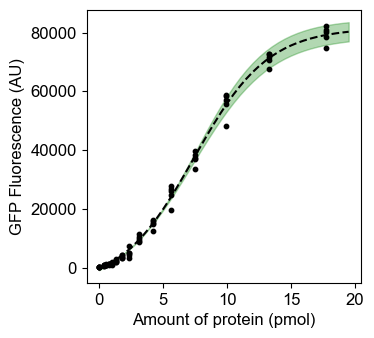

In [12]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

plt.rcParams['font.size'] = 12


df = pd.read_excel('/'.join([data_folder,'sample_calibration_curve.xlsx']))
cutoff = 20
df = df[df['Cat pmol'] < cutoff]
xdata=np.array(df['Cat pmol'])
ydata=np.array(df['GFP'])

p0 = [max(ydata), np.median(xdata),1,min(ydata)] # this is a mandatory initial guess

popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')
sigma_ab = np.sqrt(np.diagonal(pcov))

x_fit = np.arange(0,cutoff,0.5)

bound_upper = sigmoid(x_fit, *(popt + sigma_ab))
bound_lower = sigmoid(x_fit, *(popt - sigma_ab))

fig,ax = plt.subplots(figsize=[9*cm,9*cm])

plt.fill_between(x_fit, bound_lower, bound_upper,
                 color = 'green', alpha = 0.3)

y_fit = sigmoid(x_fit,*popt)
y_pred = sigmoid(xdata, *popt)
score = round(r2_score(ydata, y_pred),3)
print(f'R2 score for fit: {score}')
plt.scatter(xdata,ydata,color='black',s=10)
plt.plot(x_fit,y_fit,color='black',ls='--')
plt.xlabel('Amount of protein (pmol)')
plt.ylabel('GFP Fluorescence (AU)')

# plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve.svg',format='svg',dpi=300)

plt.show()

plt.rcParams['font.size'] = 7


R2 score for fit: 0.995


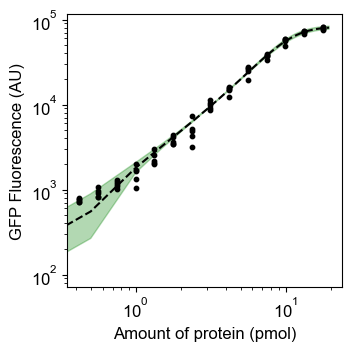

In [13]:
plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(figsize=[9*cm,9*cm])


plt.fill_between(x_fit, bound_lower, bound_upper,
                 color = 'green', alpha = 0.3)
plt.xscale('log')
plt.yscale('log')

y_fit = sigmoid(x_fit,*popt)
y_pred = sigmoid(xdata, *popt)
score = round(r2_score(ydata, y_pred),3)
print(f'R2 score for fit: {score}')
plt.scatter(xdata,ydata,color='black',s=10)
plt.plot(x_fit,y_fit,color='black',ls='--')
plt.xlabel('Amount of protein (pmol)')
plt.ylabel('GFP Fluorescence (AU)')

# plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve_log.png',format='png',dpi=300,bbox_inches='tight') # Can't render the svg file in illustrator so I switched to png for this figure
# plt.savefig(f'{fig_folder}/Supp_fig-calibration_curve_log.svg',format='svg',dpi=300,bbox_inches='tight')

plt.show()

plt.rcParams['font.size'] = 7


In [28]:
# df.to_excel(f'./{data_folder}/Supp_Fig_1C-calibration_curve.xlsx')